## import os 

In [1]:
import os
os.listdir('./data')

['dataset_for_cnn_model',
 'PA_201605-2012001更新R6(20190509).xlsx',
 'tag盤點表.xlsx',
 'train.csv',
 'train_FeatureSelected.csv',
 'train_spec_checked_and_add_target(full).csv']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch
from tqdm import tqdm_notebook as tqdm
import joblib

# Load X and y

In [10]:
dataset = joblib.load('./data/dataset_for_cnn_model')
X = dataset['X'][:10000]
y = dataset['y'].iloc[:10000]
i_lst = dataset['index']

# Visualization

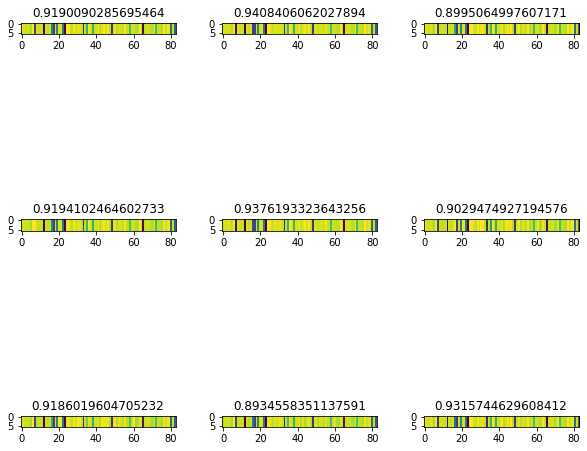

In [12]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0.3, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    idx = np.random.randint(0,len(X))
    plt.imshow(X[idx])
    plt.title(y[idx])

# reshape for ML model

In [ ]:
time_periods,num_sensors = X[0].shape
print(time_periods,num_sensors)
input_shape = time_periods*num_sensors
X = X.reshape(-1,input_shape)
print(X.shape,y.shape)

# split

In [14]:
train_len = int(len(X)*0.8)
X_train,X_test = X[:train_len],X[train_len:]
y_train,y_test = y[:train_len],y[train_len:]

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(8000, 6, 83) (8000,)
(2000, 6, 83) (2000,)


# tensor

In [15]:
X_train = torch.tensor(X_train,dtype=torch.float).cuda()
y_train = torch.tensor(y_train,dtype=torch.float).cuda()
X_test = torch.tensor(X_test,dtype=torch.float).cuda()
y_test = torch.tensor(y_test,dtype=torch.float).cuda()

# data iter

In [16]:
datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)

# Model

In [17]:
import torch
from torch import nn

class Net(torch.nn.Module):
    def __init__(self,time_size,sensor_size,output_size):
        super(Net, self).__init__()
        
        # cnn base
        self.cnn_base = nn.Sequential(
            nn.Conv1d(in_channels=time_size,out_channels=time_size,kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=time_size,out_channels=time_size,kernel_size=1),
            nn.ReLU(),
        )
        
        # target
        self.target = nn.Sequential(nn.Linear(time_size*sensor_size,128), 
                                    nn.ReLU(), 
                                    nn.Linear(128,output_size))
        
        #initialize
        self.apply(self._weights_init)
    
    @staticmethod
    def _weights_init(m):
        if hasattr(m,'weight'):
            nn.init.xavier_uniform_(m.weight).cuda()
        if hasattr(m,'bias'):    
            nn.init.constant_(m.bias,0).cuda()

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(x.shape[0],-1)
        y_pred = self.target(x)
        return y_pred

In [18]:
net = Net(X.shape[1],X.shape[2],1).cuda()
net

Net(
  (cnn_base): Sequential(
    (0): Conv1d(6, 6, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(6, 6, kernel_size=(1,), stride=(1,))
    (3): ReLU()
  )
  (target): Sequential(
    (0): Linear(in_features=498, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

# loss_function and optimizer

In [19]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# Training

In [20]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
    history = []
    for epoch in range(num_epochs):
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # end for
        history.append(loss.item())
        print("epochs {} loss {:.4f}".format(epoch,loss.item()))
    
    # end for
    plt.plot(np.array(history))
    plt.title('train loss')
    
    return net

epochs 0 loss 0.0002
epochs 1 loss 0.0002
epochs 2 loss 0.0002
epochs 3 loss 0.0002
epochs 4 loss 0.0002
epochs 5 loss 0.0001
epochs 6 loss 0.0002
epochs 7 loss 0.0002
epochs 8 loss 0.0002
epochs 9 loss 0.0002
epochs 10 loss 0.0002
epochs 11 loss 0.0003
epochs 12 loss 0.0002
epochs 13 loss 0.0002
epochs 14 loss 0.0001
epochs 15 loss 0.0002
epochs 16 loss 0.0002
epochs 17 loss 0.0002
epochs 18 loss 0.0003
epochs 19 loss 0.0002


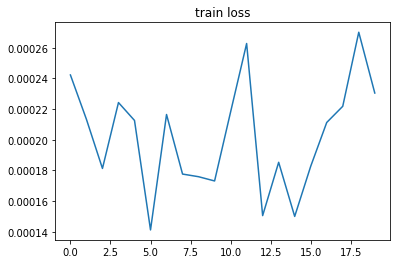

In [22]:
net = train(net,train_iter,loss_function,optimizer,num_epochs=20)

# plot predict line

In [23]:
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def metric(y_true,y_pred,name):
    t = pd.DataFrame(index=[name])
    t['r2'] = r2_score(y_true,y_pred)
    t['rmse'] = sqrt(mean_squared_error(y_true,y_pred))
    t['mape'] = mape(y_true,y_pred)
    t = t.apply(lambda x:round(x,4))
    return t

def plot_predict(y_true,y_pred,name):
    # plot
    plot_data = pd.DataFrame()
    plot_data['y_real'] = y_true
    plot_data['y_pred'] = y_pred
    n = int(len(y_pred)/100)
    plot_data.rolling(n).mean().plot()
    plt.title('move_avg {}'.format(n))
    plt.show()
    
    # score
    print(metric(y_true,y_pred,name))

In [24]:
model = net

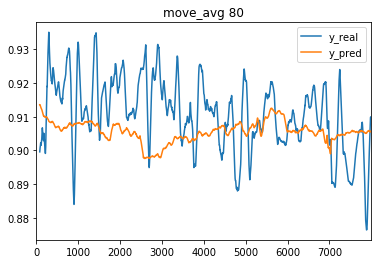

           r2    rmse    mape
train -0.2716  0.0147  1.2993


In [29]:
y_pred = model(X_train).cpu().detach().numpy().ravel()
y_real = y_train.cpu().detach().numpy().ravel()
plot_predict(y_real,y_pred,'train')

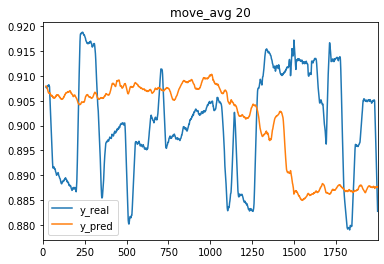

          r2    rmse    mape
test -1.0326  0.0154  1.4786


In [30]:
y_pred = model(X_test).cpu().detach().numpy().ravel()
y_real = y_test.cpu().detach().numpy().ravel()
plot_predict(y_real,y_pred,'test')